In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

<h3> Question 1

**Problem Overview**

We are tasked with analyzing the concentration of NOx and SOx in a restaurant's dining area over a 24-hour period. The restaurant operates for 12 hours (10 AM to 10 PM) and has an air exchange system with specific emission rates from an LPG stove. Additionally, decay due to adsorption and ventilation are modeled using given half-lives and air exchange rates.

**Problem Parameters:**

* **Restaurant Dimensions:**
    * Length: 10 m
    * Width: 10 m
    * Height: 3 m
* **HVAC Air Exchange Rate:** 5 exchanges per hour
* **LPG Stove Emissions:**
    * NOx: 0.2 g/s
    * SOx: 0.0002 g/s
* **Operating Hours:** 12 hours/day (10 AM - 10 PM)
* **Average Customers:** 50 customers/hour
* **Ambient Outdoor Air Concentrations:**
    * NOx: 50 ppb
    * SOx: 0.5 ppb
* **Half-Lives:**
    * NOx: 50 minutes
    * SOx: 75 minutes

**Task:**

Compute the concentration of NOx and SOx in the restaurant's dining area over a 24-hour period, considering emission, ventilation, and decay processes.

**Defines room dimensions, emission rates, working hours, outdoor pollutant levels, and decay half-lives for NOx and SOx.**

In [17]:
# Step 1: Define constants and parameters
ROOM_DIMENSIONS = (10, 10, 3)  # Dimensions in meters (length x width x height)
AIR_CHANGE_RATE_HR = 5  # Air changes per hour
NOX_EMISSION_RATE_LPG = 0.2  # NOx emission rate in g/s
SOX_EMISSION_RATE_LPG = 0.0002  # SOx emission rate in g/s
WORKING_HOURS = (10, 22)  # Working hours (10 AM to 10 PM)
OUTDOOR_NOX_LEVEL_PPB = 50  # Outdoor NOx concentration in ppb
OUTDOOR_SOX_LEVEL_PPB = 0.5  # Outdoor SOx concentration in ppb
NOX_DECAY_HALF_LIFE_HRS = 50 / 60  # NOx half-life in hours
SOX_DECAY_HALF_LIFE_HRS = 1 + 15 / 60  # SOx half-life in hours

**Converts ppb to g/m³, calculates decay constants for NOx and SOx, and derives emission rates based on room volume and air changes.**

In [58]:
# Step 2: Calculate conversion factors and constants
def convert_ppb_to_g_per_m3(ppb, molar_mass):
    return ppb * molar_mass / (24.45 * 10**9)

NOX_MOLAR_MASS = 46  # Molecular weight of NOx in g/mol
SOX_MOLAR_MASS = 64  # Molecular weight of SOx in g/mol
OUTDOOR_NOX_CONC = convert_ppb_to_g_per_m3(OUTDOOR_NOX_LEVEL_PPB, NOX_MOLAR_MASS)
OUTDOOR_SOX_CONC = convert_ppb_to_g_per_m3(OUTDOOR_SOX_LEVEL_PPB, SOX_MOLAR_MASS)

NOX_DECAY_CONSTANT = np.log(2) / (NOX_DECAY_HALF_LIFE_HRS * 3600)  # Decay constant for NOx (per second)
SOX_DECAY_CONSTANT = np.log(2) / (SOX_DECAY_HALF_LIFE_HRS * 3600)  # Decay constant for SOx (per second)

ROOM_VOLUME = np.prod(ROOM_DIMENSIONS)  # Room volume in m³
AIR_CHANGE_RATE_SEC = AIR_CHANGE_RATE_HR / 3600  # Air changes per second
NOX_EMISSION_RATE_VOL = NOX_EMISSION_RATE_LPG / ROOM_VOLUME  # NOx emission rate in g/m³/s
SOX_EMISSION_RATE_VOL = SOX_EMISSION_RATE_LPG / ROOM_VOLUME  # SOx emission rate in g/m³/s

**Defines the ODE system for NOx and SOx concentrations, considering emission rates, air changes, and decay constants during working hours.**

In [4]:
# Step 3: Define the ODE system
def compute_pollutant_concentration(t, y):
    """
    Differential equations to model indoor concentrations of NOx and SOx.
    """
    nox_level, sox_level = y
    current_time_hr = (t / 3600) % 24  # Convert time to hours within a 24-hour period

    # Check if emissions are active based on working hours
    if WORKING_HOURS[0] <= current_time_hr < WORKING_HOURS[1]:
        nox_emission = NOX_EMISSION_RATE_VOL
        sox_emission = SOX_EMISSION_RATE_VOL
    else:
        nox_emission = 0
        sox_emission = 0

    # Differential equations for NOx and SOx concentrations
    d_nox_dt = nox_emission - AIR_CHANGE_RATE_SEC * (nox_level - OUTDOOR_NOX_CONC) - NOX_DECAY_CONSTANT * nox_level
    d_sox_dt = sox_emission - AIR_CHANGE_RATE_SEC * (sox_level - OUTDOOR_SOX_CONC) - SOX_DECAY_CONSTANT * sox_level

    return [d_nox_dt, d_sox_dt]

**Sets initial concentrations based on outdoor pollutant levels and defines a 24-hour simulation period with 1000 evaluation points.**

In [5]:
# Step 4: Set initial conditions and time range
INITIAL_CONDITIONS = [OUTDOOR_NOX_CONC, OUTDOOR_SOX_CONC]  # Start with outdoor air concentrations
TIME_SPAN = (0, 24 * 3600)  # Simulate over 24 hours in seconds
TIME_EVAL_POINTS = np.linspace(0, 24 * 3600, 1000)  # Evaluate at 1000 time points

**Solves the ODE system, extracts pollutant concentrations in g/m³, and converts them back to ppb for NOx and SOx.**

In [6]:
# Step 5: Solve the ODEs
solution = solve_ivp(compute_pollutant_concentration, TIME_SPAN, INITIAL_CONDITIONS, t_eval=TIME_EVAL_POINTS, method='RK45')

# Extract time and pollutant concentrations from the solution
time_in_hours = solution.t / 3600  # Convert time to hours
nox_concentration_g_per_m3 = solution.y[0]
sox_concentration_g_per_m3 = solution.y[1]

# Convert concentrations back to ppb
nox_concentration_ppb = nox_concentration_g_per_m3 / convert_ppb_to_g_per_m3(1, NOX_MOLAR_MASS)
sox_concentration_ppb = sox_concentration_g_per_m3 / convert_ppb_to_g_per_m3(1, SOX_MOLAR_MASS)

**Plots indoor NOx and SOx concentrations over 24 hours, with outdoor levels as reference lines, in a side-by-side layout for comparison.**

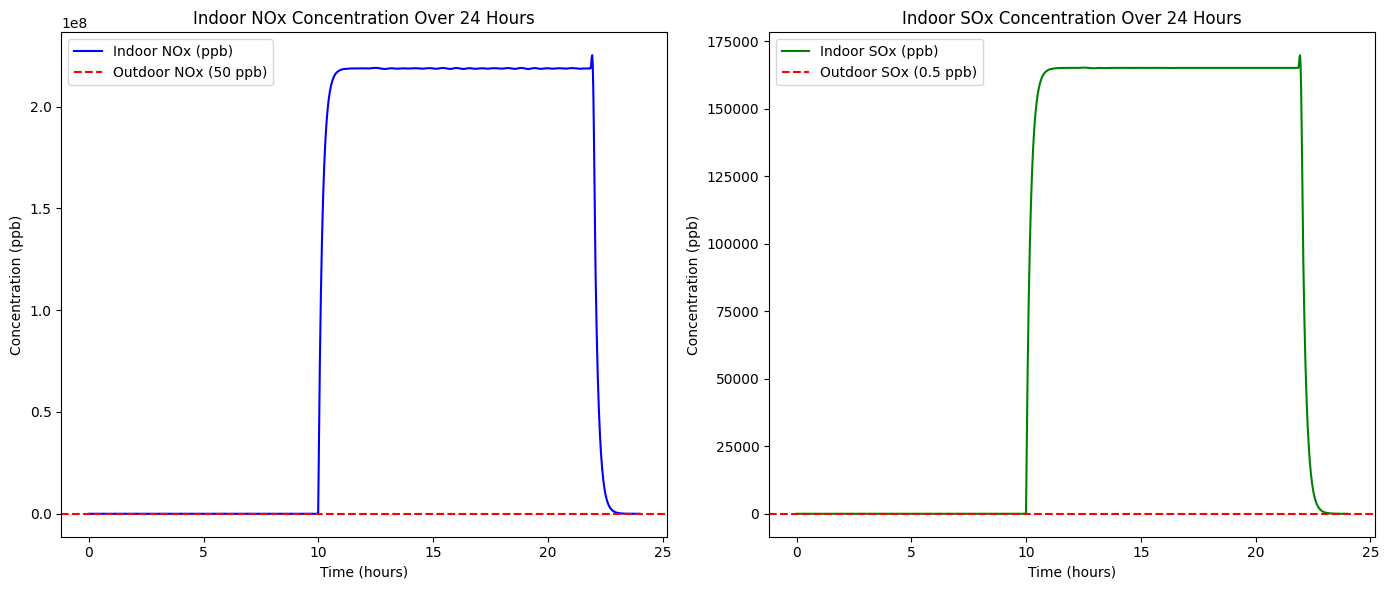

In [7]:
# Step 6: Plot the results
plt.figure(figsize=(14, 6))

# Plot NOx concentrations
plt.subplot(1, 2, 1)
plt.plot(time_in_hours, nox_concentration_ppb, label='Indoor NOx (ppb)', color='blue')
plt.axhline(OUTDOOR_NOX_LEVEL_PPB, color='red', linestyle='--', label='Outdoor NOx (50 ppb)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ppb)')
plt.title('Indoor NOx Concentration Over 24 Hours')
plt.legend()

# Plot SOx concentrations
plt.subplot(1, 2, 2)
plt.plot(time_in_hours, sox_concentration_ppb, label='Indoor SOx (ppb)', color='green')
plt.axhline(OUTDOOR_SOX_LEVEL_PPB, color='red', linestyle='--', label='Outdoor SOx (0.5 ppb)')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ppb)')
plt.title('Indoor SOx Concentration Over 24 Hours')
plt.legend()

plt.tight_layout()
plt.show()

<h3> Question 2

The average number of customers varies during the restaurant's 12-hour operation. The emission rate of NOx and SOx is proportional to the number of customers, scaled using the base emission rates for 50 customers. The hourly customer count is given below:

| Hour       | Customers |
|------------|-----------|
| 10-11 AM   | 20        |
| 11-12 PM   | 50        |
| 12-1 PM    | 80        |
| 1-2 PM     | 50        |
| 2-3 PM     | 40        |
| 3-4 PM     | 20        |
| 4-5 PM     | 30        |
| 5-6 PM     | 120       |
| 6-7 PM     | 100       |
| 7-8 PM     | 70        |
| 8-9 PM     | 40        |
| 9-10 PM    | 30        |

Develop concentration profiles of NOx and SOx in the restaurant, considering:
1. Emission rates proportional to the customer count.
2. Other parameters, including ventilation, decay constants, and initial conditions, remain the same as in the previous example.


**The code defines key parameters for simulating air quality in a restaurant. It calculates the room's volume, sets the air exchange rate, and specifies the emission rates of NOx and SOx from the LPG stove. It also sets ambient outdoor concentrations of NOx and SOx, and computes the decay constants for both pollutants based on their half-lives. These values are used to model pollutant concentrations over time.**

In [44]:
# Room dimensions (in meters)
room_length = 10  # meters
room_width = 10   # meters
room_height = 3   # meters

# Calculate the volume of the room (m³)
room_volume = room_length * room_width * room_height  # Volume in m³

# Air exchange rate (air exchanges per second)
air_exchange_rate = 5 / 3600  # 5 air exchanges per hour, converted to per second

# LPG stove emission rates (g/s)
lpg_emission_nox = 0.2  # NOx emission rate (grams per second)
lpg_emission_sox = 0.0002  # SOx emission rate (grams per second)

# Ambient outdoor air concentrations (in ppb)
outdoor_nox = 50  # NOx concentration in outdoor air (ppb)
outdoor_sox = 0.5  # SOx concentration in outdoor air (ppb)

# Decay rates: Half-life of NOx and SOx (in seconds)
half_life_nox = 50 * 60  # Half-life of NOx in seconds (50 minutes)
half_life_sox = (1 * 3600) + (15 * 60)  # Half-life of SOx in seconds (1 hour 15 minutes)

# Decay constants for NOx and SOx (using the formula k = ln(2) / half-life)
k_nox = np.log(2) / half_life_nox  # Decay constant for NOx
k_sox = np.log(2) / half_life_sox  # Decay constant for SOx

**This code defines the time step for the simulation as 1 minute (converted to hours), and then creates an array time that represents a 24-hour period with intervals of 1 minute. The np.arange function generates time values from 0 to 24 hours, with the defined step size.**

In [45]:
# Time step for simulation (in hours)
time_step = 1 / 60  # Converting 1 minute into hours (since 1 hour = 60 minutes)

# Time array from 0 to 24 hours, with the defined time step
time = np.arange(0, 24, time_step)  # Simulate for 24 hours

**The function converts a concentration in ppb to grams per cubic meter by first converting ppb to moles per cubic meter and then multiplying by the molecular weight to obtain grams.**

In [46]:
def ppb_to_grams_per_cubic_meter(ppb, molecular_weight):
    # Standard volume for 1 mole of gas at STP in m³ (0.02445 m³)
    molar_volume = 0.02445  # m³/mol

    # Convert ppb to moles per cubic meter (moles/m³)
    moles_per_cubic_meter = ppb * 1e-9  # ppb to moles (ppb * 1e-9 = moles)

    # Convert moles to grams
    grams_per_cubic_meter = moles_per_cubic_meter * molecular_weight

    return grams_per_cubic_meter

**The `customer_counts` list represents the number of customers per hour throughout a 12-hour day, and `baseline_customers` is the reference value used for scaling emissions (set to 50 customers).**

In [47]:
# Customer data
customer_counts = [20, 50, 80, 50, 40, 20, 30, 120, 100, 70, 40, 30]  # Customers per hour
baseline_customers = 50

**The function `calculate_hourly_emission_rates` scales the LPG stove's emission rates (NOx and SOx) based on the number of customers each hour, using a baseline customer count. It returns the scaled emission rates for each hour, with the scaling factor applied to the original emission rates.**

In [48]:
# Define a scaling factor based on customer activity.
# This scaling factor relates customer counts to emission rates more directly.

def calculate_hourly_emission_rates(customer_counts, baseline_customers, lpg_emission_nox, lpg_emission_sox):
    
    # Initialize lists to store the emission rates for each hour
    hourly_nox_emission_rates = []
    hourly_sox_emission_rates = []
    
    # Iterate over each hour's customer count
    for count in customer_counts:
        # Scale the emission rates based on the customer count
        scale_factor = count / baseline_customers  # Factor based on customer count
        
        # Apply the scale factor to the LPG emission rates for both NOx and SOx
        nox_emission = lpg_emission_nox * scale_factor
        sox_emission = lpg_emission_sox * scale_factor
        
        # Append to the respective lists
        hourly_nox_emission_rates.append(nox_emission)
        hourly_sox_emission_rates.append(sox_emission)
    
    return hourly_nox_emission_rates, hourly_sox_emission_rates

**The function `initialize_concentration_arrays` creates arrays for NOx and SOx concentrations, initialized to specified values (default 0), with the length matching the provided time array. It returns the two concentration arrays.**

In [49]:
def initialize_concentration_arrays(time_array, initial_concentration_nox=0, initial_concentration_sox=0):
    # Create empty arrays for concentrations
    nox_concentration = np.full_like(time_array, initial_concentration_nox)
    sox_concentration = np.full_like(time_array, initial_concentration_sox)
    
    return nox_concentration, sox_concentration

**This process calculates the NOx and SOx emissions for each hour based on customer activity, then updates their concentrations over time. The `calculate_emissions` function determines emissions during operational hours, while the `update_concentration` function adjusts concentrations based on emission rates, air exchange, outdoor concentration, and decay. The simulation iterates through the time steps, updating concentrations for NOx and SOx accordingly.**

In [50]:
def calculate_emissions(hour, customer_counts, baseline_customers, hourly_nox_emission_rates, hourly_sox_emission_rates, room_volume):
    if 10 <= hour < 22:  # Operational hours (10 AM - 10 PM)
        hour_index = hour - 10
        nox_emission = (customer_counts[hour_index] / baseline_customers) * hourly_nox_emission_rates[hour_index] / room_volume
        sox_emission = (customer_counts[hour_index] / baseline_customers) * hourly_sox_emission_rates[hour_index] / room_volume
    else:  # Non-operational hours
        nox_emission = 0
        sox_emission = 0
        
    return nox_emission, sox_emission

def update_concentration(concentration_previous, emission_rate, time_step, air_exchange_rate, outdoor_concentration, decay_constant):
    updated_concentration = concentration_previous + \
                            (emission_rate * time_step * 3600) - \
                            (concentration_previous - ppb_to_grams_per_cubic_meter(outdoor_concentration, 46)) * air_exchange_rate * time_step - \
                            concentration_previous * decay_constant * time_step
    return updated_concentration

# Time Simulation
for i in range(1, len(time)):
    current_hour = int(time[i])
    
    # Calculate emissions for the current hour
    nox_emission, sox_emission = calculate_emissions(current_hour, customer_counts, baseline_customers, hourly_nox_emission_rates, hourly_sox_emission_rates, room_volume)

    # Update NOx and SOx concentrations using separate functions
    nox_concentration_sim[i] = update_concentration(nox_concentration_sim[i - 1], nox_emission, time_step, air_exchange_rate, outdoor_nox, k_nox)
    sox_concentration_sim[i] = update_concentration(sox_concentration_sim[i - 1], sox_emission, time_step, air_exchange_rate, outdoor_sox, k_sox)

**This process converts the simulated concentrations of NOx and SOx from grams per cubic meter to parts per billion (ppb) using the `convert_to_ppb` function. It applies the conversion for each concentration value in the NOx and SOx concentration arrays, utilizing the molecular weights of NOx (46) and SOx (64).**

In [51]:
def convert_to_ppb(concentration, molecular_weight, standard_conditions_temp=298, gas_constant=8.314):
    return concentration / (molecular_weight / (gas_constant * standard_conditions_temp)) * 1e9  # Convert to ppb

# Convert NOx and SOx concentrations to ppb
nox_concentration_sim_ppb = np.array([convert_to_ppb(c, 46) for c in nox_concentration_sim])
sox_concentration_sim_ppb = np.array([convert_to_ppb(c, 64) for c in sox_concentration_sim])

**This process defines a function `plot_concentration_profile` to plot the concentration profiles of NOx and SOx over 24 hours. It takes the time array, concentration data, outdoor concentration, gas label, color, and subplot position as inputs. The function is used to plot NOx and SOx concentrations in separate subplots, with the outdoor concentration indicated by a red dashed line. The plots are then displayed in a 14x6 figure layout.**

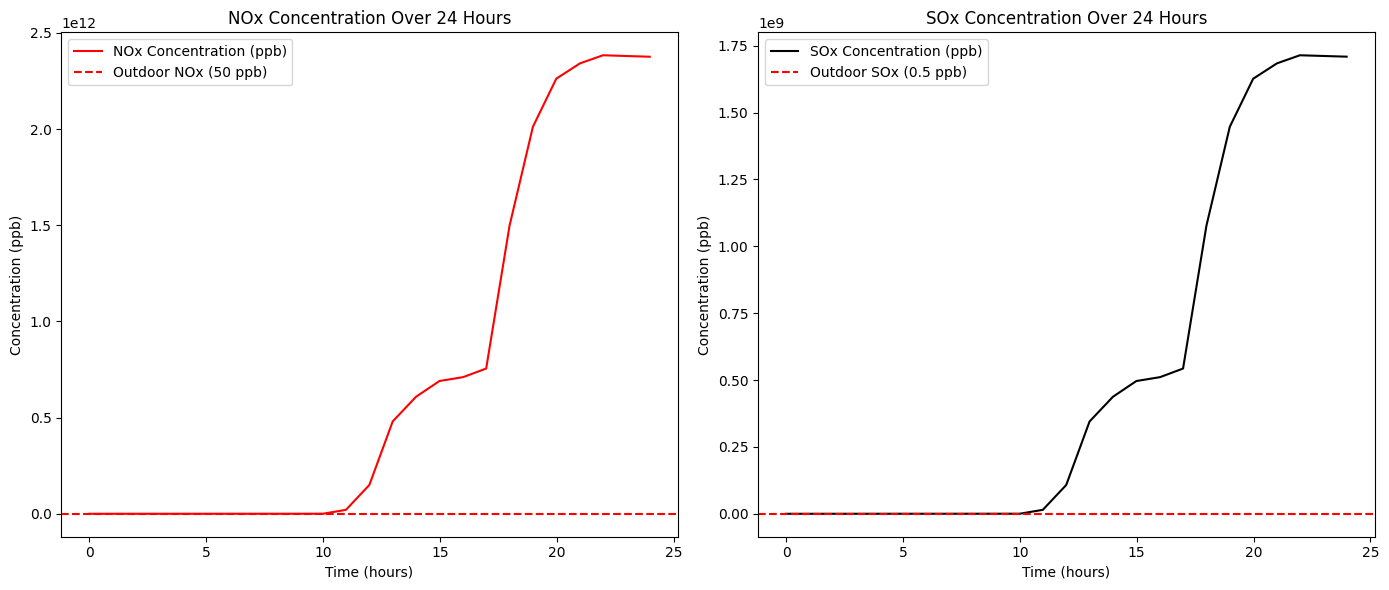

In [52]:
def plot_concentration_profile(time, concentration_data, outdoor_concentration, gas_label, color, subplot_position):
    plt.subplot(1, 2, subplot_position)
    plt.plot(time, concentration_data, label=f'{gas_label} Concentration (ppb)', color=color)
    plt.axhline(outdoor_concentration, color='r', linestyle='--', label=f'Outdoor {gas_label} ({outdoor_concentration} ppb)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Concentration (ppb)')
    plt.title(f'{gas_label} Concentration Over 24 Hours')
    plt.legend()

# Visualization
plt.figure(figsize=(14, 6))

# Plot NOx concentration profile
plot_concentration_profile(time, nox_concentration_sim_ppb, outdoor_nox, 'NOx', 'red', 1)

# Plot SOx concentration profile
plot_concentration_profile(time, sox_concentration_sim_ppb, outdoor_sox, 'SOx', 'black', 2)

plt.tight_layout()
plt.show()

<h3> Question 3

### Problem Statement

A carpeted area of $80 \, \text{m}^2$ in a commercial establishment emits formaldehyde (HCHO) at a rate of 0.05 mg/m$^2$.h at 22°C. The emission rate changes with temperature as follows:

* **Increase by 2%** per degree above 22°C
* **Decrease by 1%** per degree below 22°C

The establishment is $10 \, \text{m} \times 10 \, \text{m} \times 3 \, \text{m}$ in volume, with the following temperatures over 24 hours:

* **Morning (6 hours):** 10°C
* **Afternoon (6 hours):** 25°C
* **Evening (6 hours):** 22°C
* **Night (6 hours):** 15°C

Compute the concentration of formaldehyde (HCHO) in a glass of water left in the room. The calculations consider the following:

* **Henry's Law Constant (H):**
  * H = 5020 M/atm at 293 K
  * Temperature dependence given by:
    $$
    \ln H = \frac{6423 \pm 542}{T} - (13.4 \pm 2.0),
    $$
    where *T* is in Kelvin.


**Defines room parameters, emission rates, temperature-based emission changes, and environmental conditions for various day periods.**

In [59]:
# Constants and Parameters
room_area = 10 * 10  # m²
room_volume = 10 * 10 * 3  # m³
carpet_area = 80  # m²
base_emission_rate = 0.05  # mg/m²·h at 22°C
temp_change_above = 0.02  # +2% per degree above 22°C
temp_change_below = -0.01  # -1% per degree below 22°C

H_ref = 5020  # M/atm at 293 K
A = 6423  # Arrhenius numerator
B = -13.4  # Arrhenius offset
T_ref = 293  # Reference temperature (K)

time_periods = [6, 6, 6, 6]  # hours for Morning, Afternoon, Evening, Night
temperatures = [10, 25, 22, 15]  # °C for Morning, Afternoon, Evening, Night

**The code calculates total time, cumulative time intervals, and converts temperatures from Celsius to Kelvin.**

In [60]:
# Time and Temperature Representation
total_time_hours = sum(time_periods)
time_intervals = np.cumsum(time_periods)
temperatures_K = [temp + 273.15 for temp in temperatures]

**The function calculates the emission rate based on the current time and temperature difference from 22°C, adjusting the rate according to temperature changes for each time period.**

In [61]:
# Emission Rate Function
def emission_rate(t):
    hour = (t / 3600) % total_time_hours  # Get current hour
    for i, interval in enumerate(time_intervals):
        if hour < interval:
            delta_T = temperatures[i] - 22
            if delta_T > 0:
                return base_emission_rate * (1 + delta_T * temp_change_above) * carpet_area / room_volume
            else:
                return base_emission_rate * (1 + delta_T * temp_change_below) * carpet_area / room_volume
    return 0

**The function calculates Henry's constant based on the current temperature for each time interval, using the Arrhenius equation. If no interval matches, it returns the default constant.**

In [62]:
# Henry's Constant Function
def henrys_constant(t):
    hour = (t / 3600) % total_time_hours
    for i, interval in enumerate(time_intervals):
        if hour < interval:
            T = temperatures_K[i]
            ln_H = (A / T) + B
            return np.exp(ln_H)
    return np.exp((A / T_ref) + B)

**The function calculates the rate of change of formaldehyde concentration in air and water using emission rates and Henry's law, returning the derivatives for use in an ODE solver.**

In [63]:
# ODE System
def hcho_ode(t, y):
    C_air = y[0]  # Air concentration (mg/m³)
    C_water = y[1]  # Water concentration (mg/L)
    rate = emission_rate(t)
    H = henrys_constant(t)
    
    # Rate equations
    dC_air_dt = rate - (C_air / H)  # Emission into air and dissolution into water
    dC_water_dt = C_air / H  # Dissolution into water
    return [dC_air_dt, dC_water_dt]

**The initial concentrations of formaldehyde in air and water are set to zero.**

In [64]:
# Initial Conditions
initial_conditions = [0, 0]  # Start with zero concentrations in air and water

**Defines the time span for the simulation and sets 1000 evaluation points within the time range.**

In [65]:
# Time Span and Evaluation Points
t_span = (0, total_time_hours * 3600)
t_eval = np.linspace(0, total_time_hours * 3600, 1000)

**Solves the ODE system using the DOP853 method, a higher-order Runge-Kutta method, with the specified time span, initial conditions, and evaluation points.**

In [66]:
# Solve ODEs
solution = solve_ivp(hcho_ode, t_span, initial_conditions, t_eval=t_eval, method='DOP853')

**Extracts air and water concentration data, then plots formaldehyde concentration over time with labels, legends, and grid for clarity.**

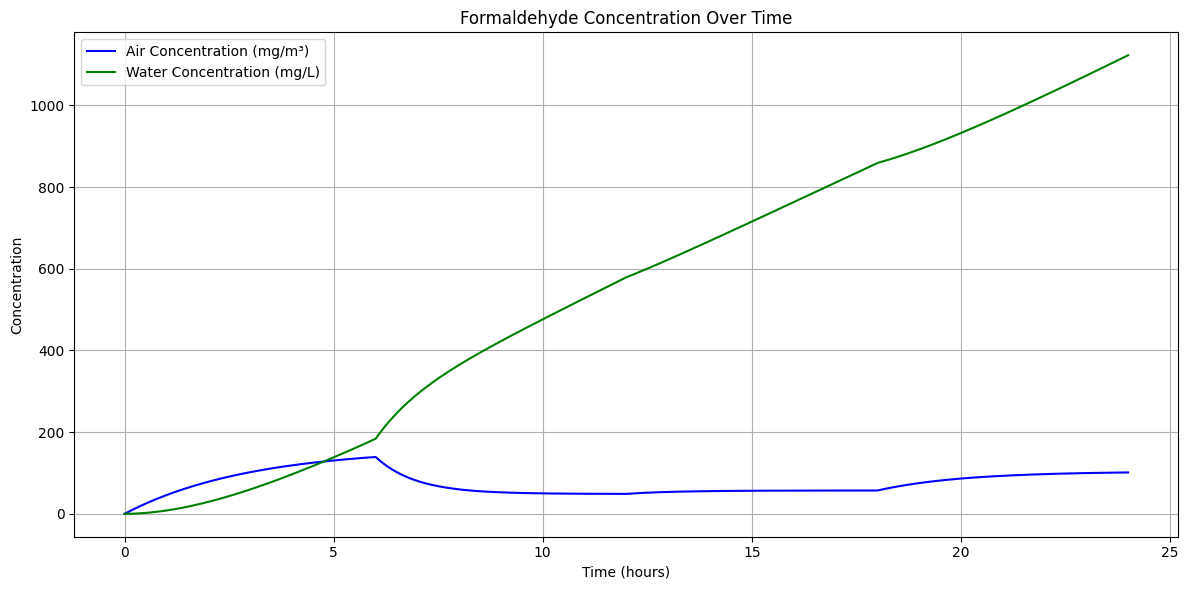

In [67]:
# Extract Results
time_hours = solution.t / 3600  # Convert time to hours
C_air = solution.y[0]  # Air concentration (mg/m³)
C_water = solution.y[1]  # Water concentration (mg/L)

# Plot Results
plt.figure(figsize=(12, 6))

# Air Concentration
plt.plot(time_hours, C_air, label='Air Concentration (mg/m³)', color='blue')

# Water Concentration
plt.plot(time_hours, C_water, label='Water Concentration (mg/L)', color='green')

# Add Labels and Legends
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Formaldehyde Concentration Over Time')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()